**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC4029 - Ciencia y analítica de datos**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

**Semana 7**
Análisis de Componentes Principales (PCA)

---

| NOMBRE | MATRÍCULA  |
|--------|------------|
| Carlos Avila Arguello | A01796133 |
| Carlos Pano Hernández | A01066264 |
| Hiram Garcia Austria | A00378771 |
| Javier Emmanuel García Escobedo | A01411206|

In [608]:
import os
DIR = "./"
os.chdir(DIR)

In [609]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import LabelEncoder

In [610]:
# Regla de Scott para calcular el número de intervalos (bins) en un histograma
def scott_rule(data):
    n = len(data)
    sigma = np.std(data)
    bin_width = 3.5 * sigma / np.cbrt(n)
    k = (np.max(data) - np.min(data)) / bin_width
    return int(np.ceil(k))

In [611]:
def myplot(score,coeff,labels=None,out=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    sns.scatterplot(x=xs*scalex, y=ys*scaley, hue=out, legend=False)

    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))

In [612]:
cereals_df = pd.read_csv('data/cereals.csv')
cereals_df

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100%_Bran,N,C,70,4,1,130,10.0,5.0,6.0,280.0,25,3,1.0,0.33,68.402973
1,100%_Natural_Bran,Q,C,120,3,5,15,2.0,8.0,8.0,135.0,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5.0,320.0,25,3,1.0,0.33,59.425505
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14.0,8.0,0.0,330.0,25,3,1.0,0.50,93.704912
4,Almond_Delight,R,C,110,2,2,200,1.0,14.0,8.0,NaN,25,3,1.0,0.75,34.384843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,G,C,110,2,1,250,0.0,21.0,3.0,60.0,25,3,1.0,0.75,39.106174
73,Trix,G,C,110,1,1,140,0.0,13.0,12.0,25.0,25,2,1.0,1.00,27.753301
74,Wheat_Chex,R,C,100,3,1,230,3.0,17.0,3.0,115.0,25,1,1.0,0.67,49.787445
75,Wheaties,G,C,100,3,1,200,3.0,17.0,3.0,110.0,25,1,1.0,1.00,51.592193


# **Parte 1**. EDA y preprocesamiento

1. Obtén estadísticas descriptivas para todas las variables del dataframe. 

In [613]:
# Estadísticas descriptivas de las variables numéricas
cereals_df.describe().T

,count,mean,std,min,25%,50%,75%,max
calories,77.0,106.883117,19.484119,50.000000,100.000000,110.000000,110.000000,160.000000
protein,77.0,2.545455,1.094790,1.000000,2.000000,3.000000,3.000000,6.000000
fat,77.0,1.012987,1.006473,0.000000,0.000000,1.000000,2.000000,5.000000
sodium,77.0,159.675325,83.832295,0.000000,130.000000,180.000000,210.000000,320.000000
fiber,77.0,2.151948,2.383364,0.000000,1.000000,2.000000,3.000000,14.000000
carbo,76.0,14.802632,3.907326,5.000000,12.000000,14.500000,17.000000,23.000000
sugars,76.0,7.026316,4.378656,0.000000,3.000000,7.000000,11.000000,15.000000
potass,75.0,98.666667,70.410636,15.000000,42.500000,90.000000,120.000000,330.000000
vitamins,77.0,28.246753,22.342523,0.000000,25.000000,25.000000,25.000000,100.000000
shelf,77.0,2.207792,0.832524,1.000000,1.000000,2.000000,3.000000,3.000000


In [614]:
# Estadísticas descriptivas de las variables categóricas
cereals_df.describe(include='object').T

,count,unique,top,freq
name,77,77,100%_Bran,1
mfr,77,7,K,23
type,77,2,C,74


Genera algunos gráficos para familiarizarte con el conjunto de datos. Al menos deberás incluir los que te permitan responder los siguientes cuestionamientos:

**Nota.** Debes responder de manera explícita las preguntas, apoyándote de los resultados observados de cada gráfico. 

2a) ¿Cuál es la frecuencia o conteo de cada categoría para las variables: `mfr` y `shelf` (por separado)? 

In [615]:
# Cálculo de frecuencias por variable
def calculateFrequencyAndPlot(df, columnName):
    frequency = df[columnName].value_counts()

    plt.figure(figsize=(8, 6))
    frequency.plot(kind='bar', color='lightgreen', edgecolor='green')
    plt.title(f"Frequency of the variable '{columnName}'")
    plt.xlabel(f"Values of '{columnName}'")
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("Frequencies for variable", columnName + ":")
    for category, frequency in frequency.items():
        print(f"Variable '{category}' on {columnName} repeats: {frequency} times")

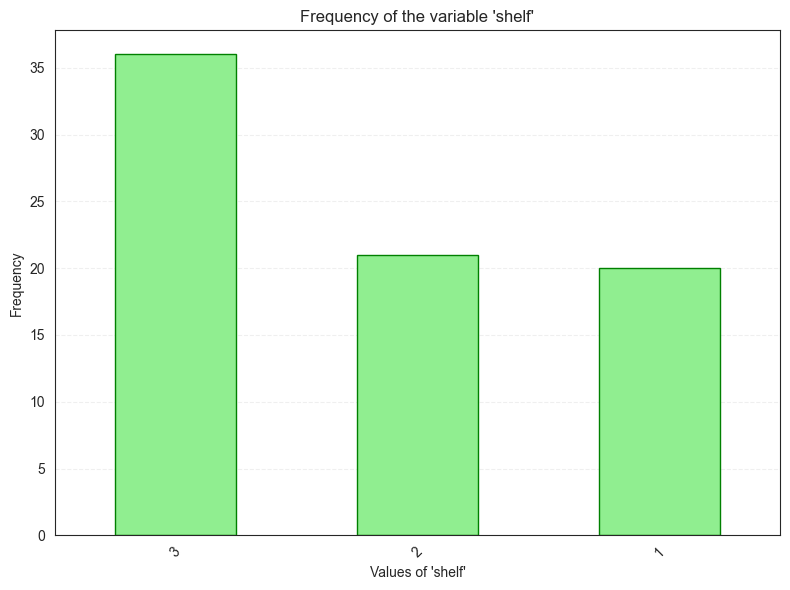

Frequencies for variable shelf:
Variable '3' on shelf repeats: 36 times
Variable '2' on shelf repeats: 21 times
Variable '1' on shelf repeats: 20 times


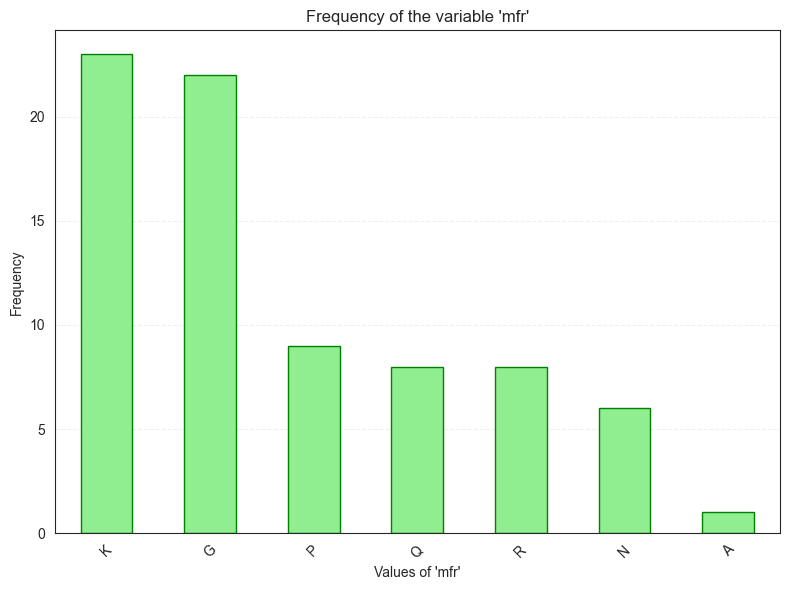

Frequencies for variable mfr:
Variable 'K' on mfr repeats: 23 times
Variable 'G' on mfr repeats: 22 times
Variable 'P' on mfr repeats: 9 times
Variable 'Q' on mfr repeats: 8 times
Variable 'R' on mfr repeats: 8 times
Variable 'N' on mfr repeats: 6 times
Variable 'A' on mfr repeats: 1 times


In [616]:
# Conteo de frecuencia para variable "shelf"
calculateFrequencyAndPlot(cereals_df, 'shelf')

# Conteo de frecuencia para variable "mfr"
calculateFrequencyAndPlot(cereals_df, 'mfr')

2b) Combina los resultados previos para observar, de cada fabricante, cuántos productos tiene en cada estante. 

In [617]:
# Combinacion de las variables 'shelf' y 'mfr'
combinacion_shelf_mfr = pd.crosstab(cereals_df['mfr'], cereals_df['shelf'])
combinacion_shelf_mfr

shelf,1,2,3
mfr,,,
A,0,1,0
G,6,7,9
K,4,7,12
N,3,2,1
P,2,1,6
Q,1,3,4
R,4,0,4


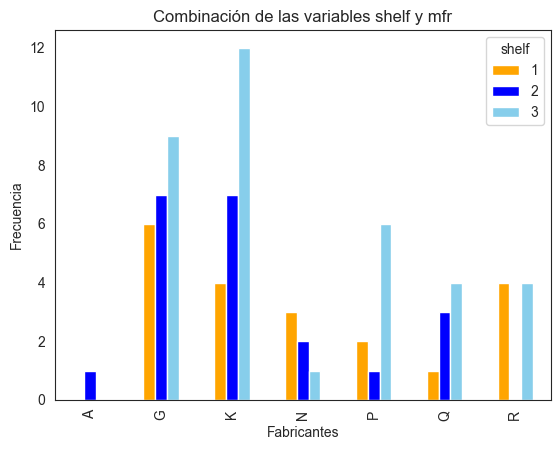

In [618]:
# Gráfico de barras de la combinación de las variables 'shelf' y 'mfr'
combinacion_shelf_mfr.plot(kind='bar', color=['orange', 'blue', 'skyblue'])
plt.title('Combinación de las variables shelf y mfr')
plt.xlabel('Fabricantes')
plt.ylabel('Frecuencia')
plt.show()

 3a) ¿Cuál es el rango más frecuente de la variable `rating`?

Número de intervalos: 7


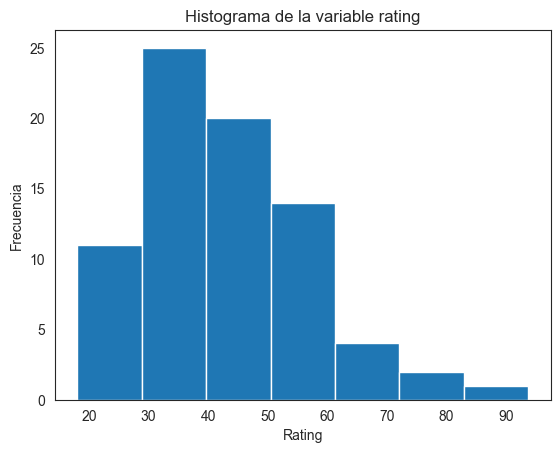

In [619]:
# Cálculo del número de intervalos para el histograma
rating_bins = scott_rule(cereals_df['rating'])

print('Número de intervalos:', rating_bins)

# Histograma de la variable 'rating'
rating_histograma = plt.hist(cereals_df['rating'], bins=rating_bins)
plt.title('Histograma de la variable rating')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()

In [620]:
# Verificando los datos del histograma, devuelve dos arrays 
# El primer array contiene la frecuencia de cada intervalo
# El segundo array contiene los límites de cada intervalo
rating_histograma

(array([11., 25., 20., 14.,  4.,  2.,  1.]),
 array([18.042851  , 28.85171686, 39.66058271, 50.46944857, 61.27831443,
        72.08718029, 82.89604614, 93.704912  ]),
 <BarContainer object of 7 artists>)

El histograma muestra claramente que el segundo rango es el que tiene mayor frecuencia.

Al imprimir los datos que usa el histograma, comprobamos que el 25 es el valor mas alto, el cual se encuentra en el segundo intervalo.

Los limites del segundo intervalo son de 28.85171686 hasta 39.66058271

Esto significa que el segundo rango es el mas frecuente, con 25 observaciones.

3b) ¿Cuáles son los 10 cereales mejor evaluados y a qué fabricante corresponden? 

In [621]:
# Ordenamiento de cereales por medio de la variable 'rating'
top_10_cereales = cereals_df.nlargest(10, 'rating')

# Selección de columnas, agregando el nombre del fabricante
top_10_cereales[['name', 'rating', 'mfr']]

,name,rating,mfr
3,All-Bran_with_Extra_Fiber,93.704912,K
64,Shredded_Wheat_'n'Bran,74.472949,N
65,Shredded_Wheat_spoon_size,72.801787,N
0,100%_Bran,68.402973,N
63,Shredded_Wheat,68.235885,N
20,Cream_of_Wheat_(Quick),64.533816,N
55,Puffed_Wheat,63.005645,Q
54,Puffed_Rice,60.756112,Q
50,Nutri-grain_Wheat,59.642837,K
2,All-Bran,59.425505,K


4a) Compara la distribución de las calorías según el fabricante, por medio de boxplots. 

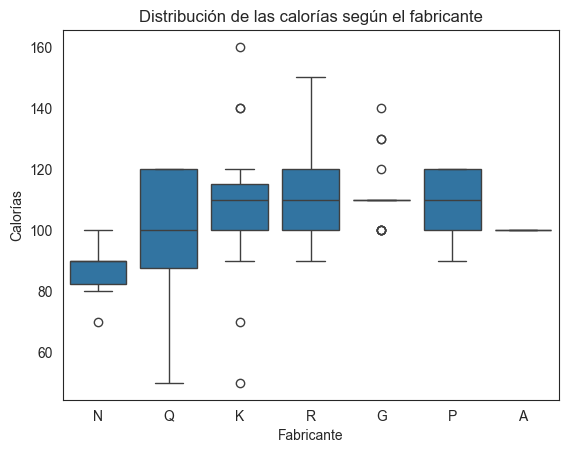

In [622]:
sns.boxplot(x='mfr', y='calories', data=cereals_df)
plt.title('Distribución de las calorías según el fabricante')
plt.xlabel('Fabricante')
plt.ylabel('Calorías')
plt.show()

4b) ¿Cuáles son las dos variables que tienen mayor correlación con `rating`? 

In [623]:
# Identificando las variables numéricas
numeric_vars = cereals_df.select_dtypes(include='number').columns
correlacion = cereals_df[numeric_vars].corr()

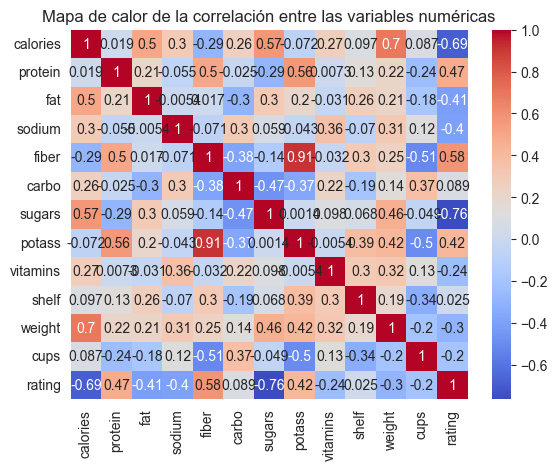

<Figure size 1000x800 with 0 Axes>

In [624]:
# Generando un mapa de calor para visualizar la correlación entre las variables numéricas
sns.heatmap(correlacion, annot=True, cmap='coolwarm')
plt.title('Mapa de calor de la correlación entre las variables numéricas')

# Incrementando el tamaño de la figura para una mejor visualización
plt.figure(figsize=(10, 8))
plt.show()

Como podemos observar en el mapa de calor, las variables "fiber" y "potass" son las que tienen una mayor correlación con "rating", ambas con 0.91

5. Elimina todos los registros con algún dato faltante y reinicia el índice del dataframe para que quede con valores consecutivos. 

In [625]:
# Verificando los valores faltantes
cereals_df.isnull().sum()


name        0
mfr         0
type        0
calories    0
protein     0
fat         0
sodium      0
fiber       0
carbo       1
sugars      1
potass      2
vitamins    0
shelf       0
weight      0
cups        0
rating      0
dtype: int64

In [626]:
# Eliminando los registros con valores faltantes
cereals_df = cereals_df.dropna()

# Corroborando que se eliminaron los valores faltantes
cereals_df.isnull().sum()

name        0
mfr         0
type        0
calories    0
protein     0
fat         0
sodium      0
fiber       0
carbo       0
sugars      0
potass      0
vitamins    0
shelf       0
weight      0
cups        0
rating      0
dtype: int64

In [627]:
# Reiniciando el indice del data frame para obtener valores consecutivos
cereals_df = cereals_df.reset_index(drop=True)

# Verificando el nuevo tamaño del data frame
cereals_df

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100%_Bran,N,C,70,4,1,130,10.0,5.0,6.0,280.0,25,3,1.0,0.33,68.402973
1,100%_Natural_Bran,Q,C,120,3,5,15,2.0,8.0,8.0,135.0,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5.0,320.0,25,3,1.0,0.33,59.425505
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14.0,8.0,0.0,330.0,25,3,1.0,0.50,93.704912
4,Apple_Cinnamon_Cheerios,G,C,110,2,2,180,1.5,10.5,10.0,70.0,25,1,1.0,0.75,29.509541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Triples,G,C,110,2,1,250,0.0,21.0,3.0,60.0,25,3,1.0,0.75,39.106174
70,Trix,G,C,110,1,1,140,0.0,13.0,12.0,25.0,25,2,1.0,1.00,27.753301
71,Wheat_Chex,R,C,100,3,1,230,3.0,17.0,3.0,115.0,25,1,1.0,0.67,49.787445
72,Wheaties,G,C,100,3,1,200,3.0,17.0,3.0,110.0,25,1,1.0,1.00,51.592193


# **Parte 2**. Ingeniería de características

6. Considerando que `rating` es la variable de salida, almacénala en una variable `y` y separa los predictores **numéricos** en `X`. Escala los valores de `X` y aplica `PCA` para proyectar los datos en el nuevo espacio de vectores. 

In [628]:
# Separando variables de entrada (x)
object_vars = cereals_df.select_dtypes(exclude='number')
x = cereals_df.iloc[:,0:-1]
x.drop(object_vars.columns, axis=1, inplace=True)

# Comprobando predictores numéricos en x
x.head(3)

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
0,70,4,1,130,10.0,5.0,6.0,280.0,25,3,1.0,0.33
1,120,3,5,15,2.0,8.0,8.0,135.0,0,3,1.0,1.00
2,70,4,1,260,9.0,7.0,5.0,320.0,25,3,1.0,0.33


In [629]:
# Separando variable rating en (y)
y = cereals_df.loc[:,'rating']

In [630]:
# Total de componentes
total_components = x.shape[1]

escalar = StandardScaler()
x_scaled = escalar.fit_transform(x)

In [631]:
# Aplicando prueba PCA con X escalado
pca = PCA()
x_projected = pca.fit_transform(x_scaled)
x_projected = pd.DataFrame(x_projected)

In [632]:
print("Los valores propios (eigenvalues) para la matriz de covarianza de nuestros datos de cereales son: ", list(np.round(pca.explained_variance_, decimals=8)))

Los valores propios (eigenvalues) para la matriz de covarianza de nuestros datos de cereales son:  [3.36484971, 2.68343251, 1.81049205, 1.0315095, 0.99776211, 0.69922773, 0.66888458, 0.42176628, 0.31802842, 0.09305466, 0.05706436, 0.01831167]


In [633]:
for i in range(0, total_components):
  print("El porcentaje de varianza explicada por el componente principal", i+1, "es", format(pca.explained_variance_ratio_[i]*100,'.0f'),'%')

El porcentaje de varianza explicada por el componente principal 1 es 28 %
El porcentaje de varianza explicada por el componente principal 2 es 22 %
El porcentaje de varianza explicada por el componente principal 3 es 15 %
El porcentaje de varianza explicada por el componente principal 4 es 8 %
El porcentaje de varianza explicada por el componente principal 5 es 8 %
El porcentaje de varianza explicada por el componente principal 6 es 6 %
El porcentaje de varianza explicada por el componente principal 7 es 5 %
El porcentaje de varianza explicada por el componente principal 8 es 3 %
El porcentaje de varianza explicada por el componente principal 9 es 3 %
El porcentaje de varianza explicada por el componente principal 10 es 1 %
El porcentaje de varianza explicada por el componente principal 11 es 0 %
El porcentaje de varianza explicada por el componente principal 12 es 0 %


In [634]:
pca.components_

array([[ 3.65940581e-02,  3.30887657e-01,  2.12548775e-01,
        -5.08936595e-02,  4.58623301e-01, -2.68608955e-01,
         8.14399579e-02,  5.02603054e-01,  1.88385579e-02,
         3.08929353e-01,  2.57160143e-01, -3.71153758e-01],
       [ 5.71142024e-01, -4.53671747e-02,  2.49143226e-01,
         3.04684185e-01, -2.01029311e-01,  1.75660427e-01,
         3.64843914e-01, -7.03449944e-02,  3.00573874e-01,
         6.51144332e-02,  4.48962056e-01,  1.06552657e-01],
       [-7.79270170e-02,  3.26405299e-01, -2.91274339e-01,
         3.43107899e-01,  1.73911820e-01,  5.13002361e-01,
        -4.95337842e-01,  1.30459589e-01,  3.27562539e-01,
         5.45932482e-04,  1.22029586e-01,  8.26947954e-02],
       [-1.64031814e-01, -2.81264931e-01, -1.24324404e-01,
        -1.68915569e-01, -7.52953200e-02, -7.13054808e-02,
         1.60328426e-02, -1.12708399e-01,  5.94798467e-01,
         6.67702679e-01, -1.60396224e-01, -3.06830647e-02],
       [ 1.86667486e-01,  3.72133552e-01,  5.9742185

7. Obtén la curva del porcentaje de varianza acumulada y determine el número mínimo de componentes principales que explique más del 90% de la varianza. Imprime la información de dichos componentes. 

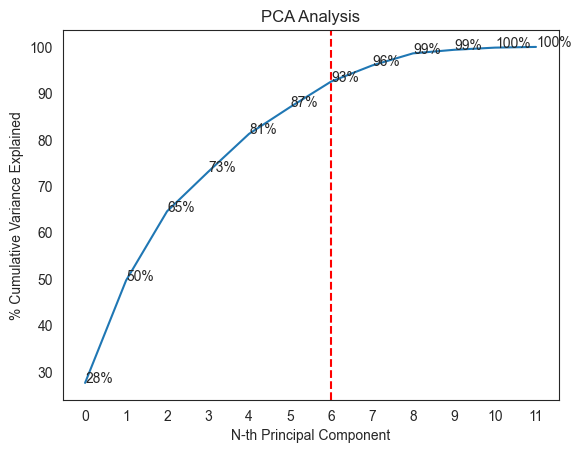

In [635]:
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.title('PCA Analysis')
plt.xlabel('N-th Principal Component')
plt.ylabel('% Cumulative Variance Explained')
plt.xticks(np.arange(0, total_components, 1))

labels = np.cumsum(pca.explained_variance_ratio_) * 100
for i in range(total_components):
    plt.text(i, labels[i], str(format(labels[i], '.0f')) + '%')

# Find the index where cumulative variance exceeds 90%
index_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) * 100 >= 90)
plt.axvline(x=index_90, color='r', linestyle='--')

plt.show()

A partir de nuestro gráfico, el número de componentes que abarcar un 90% de los datos es **7** (línea roja). Obervamos a continuación dichos componentes:

In [636]:
num_components = 7
pc_df = pd.DataFrame(abs(pca.components_[:num_components]), columns = x.columns, index=['Principal component {}'.format(i) for i in range(1, num_components + 1)])
pc_df

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
Principal component 1,0.036594,0.330888,0.212549,0.050894,0.458623,0.268609,0.081440,0.502603,0.018839,0.308929,0.257160,0.371154
Principal component 2,0.571142,0.045367,0.249143,0.304684,0.201029,0.175660,0.364844,0.070345,0.300574,0.065114,0.448962,0.106553
Principal component 3,0.077927,0.326405,0.291274,0.343108,0.173912,0.513002,0.495338,0.130460,0.327563,0.000546,0.122030,0.082695
Principal component 4,0.164032,0.281265,0.124324,0.168916,0.075295,0.071305,0.016033,0.112708,0.594798,0.667703,0.160396,0.030683
Principal component 5,0.186667,0.372134,0.597422,0.292344,0.229653,0.191830,0.360371,0.124888,0.105582,0.265485,0.232905,0.115826
Principal component 6,0.196806,0.176822,0.299822,0.462005,0.084635,0.446257,0.061289,0.068499,0.279949,0.133268,0.316544,0.464295
Principal component 7,0.062276,0.260647,0.247778,0.608269,0.095668,0.026962,0.186843,0.147455,0.168034,0.124162,0.186826,0.593052


8. ¿Cuáles son las tres variables más importantes en el cálculo del primer componente?


In [637]:
num_components = 1
pc_df = pd.DataFrame(abs(pca.components_[:num_components]), columns = x.columns, index=['Principal component {}'.format(i) for i in range(1, num_components + 1)])
pc_df

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
Principal component 1,0.036594,0.330888,0.212549,0.050894,0.458623,0.268609,0.08144,0.502603,0.018839,0.308929,0.25716,0.371154


vitamins    0.018839
calories    0.036594
sodium      0.050894
sugars      0.081440
fat         0.212549
weight      0.257160
carbo       0.268609
shelf       0.308929
protein     0.330888
cups        0.371154
fiber       0.458623
potass      0.502603
Name: Principal component 1, dtype: float64


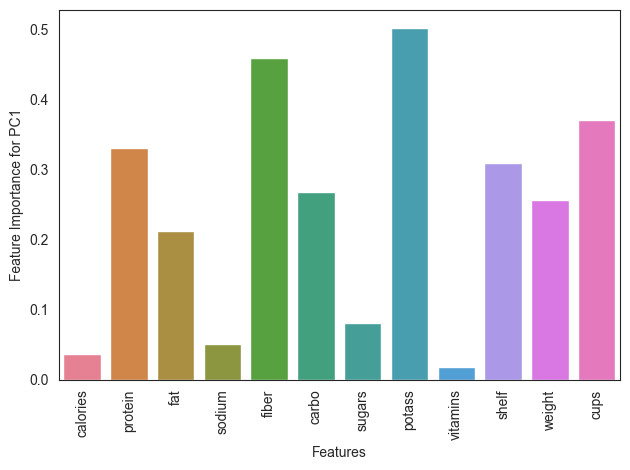

In [638]:
first_row = pc_df.iloc[0]

# Valores por categoría
print(first_row.sort_values())

sns.barplot(data=pc_df.iloc[0:1], errorbar=None)
plt.xlabel('Features')
plt.ylabel('Feature Importance for PC1')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

De acuerdo a la gráfica anterior, podemos decir que las variables más importantes en el primer componente son:

1. 'potass' -> 0.502603
2. 'fiber' -> 0.458623
3. 'cups' -> 0.371154

9. ¿Todas las variables categóricas son predictores? Aplica una técnica de encoding a las que sí lo sean. Justifica la elección de tu técnica. 

In [639]:
# Retomando las variables categóricas:
cereals_df.describe(include='object').T

,count,unique,top,freq
name,74,74,100%_Bran,1
mfr,74,7,K,23
type,74,2,C,73


No. 

El **nombre** no es una variable categórica predictora debido a que tiene puros valores únicos (no hay duplicados). No es necesario realizar un procesamiento.



La variable **type**, consta de dos posibles valores (hot/cold) que pueden interpretarse como 0/1, por lo que **sí** es una variable predictora y el OneHot Encoding es perfecta para ello por generar 1 columna binaria.


In [640]:
variables_to_encode = ['type']
encoder = OneHotEncoder(drop='first')
encoded_data = encoder.fit_transform(cereals_df[variables_to_encode])
encoded_columns = encoder.get_feature_names_out(input_features=variables_to_encode)
oneshot_df_type = pd.DataFrame(encoded_data.toarray(), columns=encoded_columns)
oneshot_df_type

,type_H
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
69,0.0
70,0.0
71,0.0
72,0.0



La variable **mfr** es una variable cetegórica, de baja cardinalidad. Al tener 7 valores únicos, podemos aplicar un 'label_encoder' para asignarle a cada categoría una valor numérico.

In [641]:
label_encoder = LabelEncoder()

# Aplicar Label Encoding a la variable "mfr"
cereals_df['mfr_encoded'] = label_encoder.fit_transform(cereals_df['mfr'])
cereals_df['mfr_encoded']

0     3
1     5
2     2
3     2
4     1
     ..
69    1
70    1
71    6
72    1
73    1
Name: mfr_encoded, Length: 74, dtype: int64

10. Conjunta, en un dataframe, las valores proyectados en los componentes seleccionados (mínimo), las transformaciones obtenidas de las variables categóricas que serán predictores y la variable de salida. Almacena el dataframe resultante en archivo. 

In [642]:
# As the cumulative percentage variance for principal components 0 to 6 is 90%
num_components = 7
cereals_rating_df = x_projected.iloc[:,0:num_components]

cereals_rating_df.columns = ['PC{}'.format(i) for i in range(1, num_components + 1)]
cereals_rating_df = pd.concat([cereals_rating_df,cereals_df['mfr_encoded'],oneshot_df_type,y], axis=1)
cereals_rating_df = cereals_rating_df.rename(columns={'type_H': 'type','mfr_encoded':'mfr'})
cereals_rating_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,mfr,type,rating
0,4.870399,-2.934238,-0.055266,0.244647,-1.102035,0.904575,0.235388,3,0.0,68.402973
1,1.761110,0.210993,-3.014058,-0.494129,3.275506,1.065041,-0.489640,5,0.0,33.983679
2,4.727161,-2.402254,0.869028,-0.095823,-1.357388,1.393861,1.210340,2,0.0,59.425505
3,5.142814,-4.401826,1.883153,0.209854,-1.662387,0.955808,-0.289695,2,0.0,93.704912
4,-0.332394,0.284619,-1.490929,-0.944313,-0.311262,0.828872,0.493652,1,0.0,29.509541
...,...,...,...,...,...,...,...,...,...,...
69,-1.059199,0.475067,1.161330,0.495373,0.749484,-0.773891,1.520184,1,0.0,39.106174
70,-1.595568,0.574653,-1.671901,0.380863,-0.489233,0.116453,-0.204196,1,0.0,27.753301
71,-0.134252,-0.612590,1.181098,-1.357046,-0.190222,0.163728,0.799693,6,0.0,49.787445
72,-0.674537,-0.568589,1.163186,-1.330649,0.088594,0.644712,-0.247744,1,0.0,51.592193


In [643]:
cereals_rating_df.to_csv('data/cereals_rating.csv')